In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context("talk")
sns.set_palette('Set2', 10)

So, yes, alright, I'm trying to show a play-by-play analysis of the Israeli GTFS for SIRI archiving purposes we have at [hasadna/open-bus](https://github.com/hasadna/open-bus).

The agenda this time is: (again, you can skip to item 3 if you're just interested in the stats, or if you already read the previous post):
1. [Get up-to-date GTFS files from the MOT FTP server](#Get-the-data)
2. [Extract the needed info from them into pandas tidy DataFrames](#Tidy-it-up)
2. [Stop and route top charts](#Stop-and-route-top-charts)
4. [On-the-road / concurrency stats](#On-the-road)
5. [A geo teaser :)](#Geo-teaser)
6. [One the next episodes](#On-the-next-episodes) Yep, not all is covered in this notebook

On the pedagogical side, I'm covering a few weird and interesting areas with Categorical columns in pandas, namely - working with [missing values and categoricals](#Stops-per-route), and [grouping on categoricals](#On-road-per-route). Categoricals can be very helpful, but that comes at a price of having to pay a somewhat careful attention when using them.

## Get the data
We get the data straight from MOT's ftp. Just so I don't repeat the last post, this went out to a separate module.

In [2]:
from gtfs_utils import *

conn = ftp_connect()
ftp_dir = get_ftp_dir(conn)
UPTODATE = 90 #days
our_uptodateness = get_uptodateness(ftp_dir)

if our_uptodateness > UPTODATE:
    get_ftp_file(conn)
    get_ftp_file(conn, file_name = 'Tariff.zip', local_zip_path = 'data/sample/tariff.zip' )

conn.quit()

'221 Goodbye.'

We load MOT's tarrif.txt file, which will give us zone names and other local info

In [3]:
tariff_df = extract_tariff_df(local_zip_path = 'data/sample/tariff.zip')
tariff_df.head()

,ShareCode,zone_name,zone_id,Daily,Weekly,Monthly,FromDate,ToDate
0,141,גוש דן,210,13.5,64.0,213.0,01/04/2016 00:00:00,01/01/2200 00:00:00
10,152,שרון,221,13.5,57.5,149.0,01/04/2016 00:00:00,01/01/2200 00:00:00
11,153,ראש העין שוהם,222,13.5,57.5,149.0,01/04/2016 00:00:00,01/01/2200 00:00:00
12,154,רחובות,223,13.5,57.5,149.0,01/04/2016 00:00:00,01/01/2200 00:00:00
13,155,נתניה,231,13.5,57.5,149.0,01/04/2016 00:00:00,01/01/2200 00:00:00


## Tidy it up
Again I'm using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [4]:
LOCAL_ZIP_PATH = 'data/sample/gtfs.zip' 

import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(LOCAL_ZIP_PATH)
service_ids = service_ids_by_date[datetime.date(2017, 12, 21)]

feed = ptg.feed(LOCAL_ZIP_PATH, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

In [5]:
s = feed.stops
s.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183939,34.917812,0,NaN,221
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,223
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984558,34.782815,0,NaN,210
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,223
4,6,38836,תחנה מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956576,34.898125,0,NaN,210


This time we need routes and trips too

In [6]:
r = feed.routes
r.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color
0,21053,2,NaN,חוף הכרמל-חיפה<->כרמיאל-כרמיאל,14122-2-1,2,NaN
1,21054,2,NaN,כרמיאל-כרמיאל<->חוף הכרמל-חיפה,14122-1-1,2,NaN
5,21060,2,NaN,כרמיאל-כרמיאל<->באר שבע מרכז-באר שבע,15123-1-3,2,NaN
6,21061,2,NaN,באר שבע מרכז-באר שבע<->כרמיאל-כרמיאל,15123-2-2,2,NaN
7,21062,2,NaN,כרמיאל-כרמיאל<->באר שבע מרכז-באר שבע,15123-1-4,2,NaN


In [7]:
t = (feed.trips
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
    )
t.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,20444,54163484,30179315_211217,יהוד מונוסון _ דרך העצמאות,0,82704
1,20444,54163484,30179316_211217,יהוד מונוסון _ דרך העצמאות,0,82704
2,20354,54163559,30180186_211217,יהוד מונוסון _ דרך העצמאות,1,82455
3,20354,54163559,30180187_211217,יהוד מונוסון _ דרך העצמאות,1,82455
4,20354,54163559,30180188_211217,יהוד מונוסון _ דרך העצמאות,1,82455


We build our DataFrame this time with two more merges in order to get route_id and route_short_name

In [8]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


In [9]:
f.dtypes

trip_id                      object
departure_time      timedelta64[ns]
arrival_time        timedelta64[ns]
stop_id                      object
date                         object
stop_name                    object
stop_lat                    float64
stop_lon                    float64
zone_id                    category
zone_name                  category
route_id                   category
route_short_name             object
route_long_name              object
dtype: object

## Stop and route top charts

### Stops per route
I'm starting this with some simple summary statistics. We do need to take into account missing values, I want the statistics to include missing names as well, so replace missing names with an empty strings seems like the way to go. 

**First pedagogical note:** Doing this with Categorical dtypes needs some extra tinkering, since we don't have a category for an empty string in the original data, so we add one.

In [10]:
f_no_nans = (f
             .assign(zone_name = lambda x: x.zone_name.cat.add_categories('').fillna(''))
             .assign(zone_id = lambda x: x.zone_id.cat.add_categories('').fillna(''))
             .assign(route_id = lambda x: x.route_id.cat.add_categories('').fillna(''))
            )
f_no_nans.fillna('')[f_no_nans.route_short_name.isnull()].head()

,trip_id,departure_time,arrival_time,stop_id,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


In [11]:
route_counts = (f_no_nans.fillna('')
 .groupby(['zone_name', 'route_id', 'route_short_name', 'route_long_name'])
 .size().sort_values(ascending=False).head(20).to_frame().rename(columns={0:'count'}))
route_counts

count
zone_name    route_id route_short_name route_long_name                                          
גוש דן       13429    1                מרכז הספורט/דרך בגין-בת ים<->תחנה מרכזית פתח תק...   9680
סובב חיפה    11685    1                תחנה מרכזית חוף כרמל/רציפים עירוני-חיפה<->מרכזי...   8946
גוש דן       13428    1                תחנה מרכזית פתח תקווה/רציפים עירוני-פתח תקווה<-...   8925
סובב חיפה    11689    1                מרכזית הקריות-קרית מוצקין<->תחנה מרכזית חוף כרמ...   8733
חבל מודיעין  11525    6                אבי עזרי א-מודיעין עילית<->מעלות החכמה-מודיעין ...   7696
             11526    6                מעלות החכמה-מודיעין עילית<->אבי עזרי ז-מודיעין ...   7350
             11524    4                מסילת ישרים/דרך קרית ספר-מודיעין עילית<->שדרות ...   6936
             11523    4                שדרות אביי ורבא /יהודה הנשיא-מודיעין עילית<->מס...   6868
             11074    2                אבני נזר/אור החיים-מודיעין עילית<->בית הכנסת קר...   6364
             11073    2                בית הכנסת קרלין-מודיעין עילית<->אבני נזר/אור הח...   6300
סובב חיפה    11308    3                בר רב האי/סעדיה הגאון-חיפה<->תחנה מרכזית חוף כר...   6160
             11309    3                תחנה מרכזית חוף כרמל/רציפים עירוני-חיפה<->בר רב...   5832
חבל מודיעין  11513    5                אבי עזרי א-מודיעין עילית<->מסילת ישרים/מסוף-מוד...   5740
גוש דן       9809     172              האורגים-חולון<->רדינג-תל אביב יפו-20                 5661
סובב ירושלים 12409    29               אריה דולצ'ין/יעקב צור-ירושלים<->דולצ'ין/בן פורת...   5564
שרון         7924     29               איזור התעשיה כפר סבא-כפר סבא<->השונית/יורדי ים-...   5548
חבל מודיעין  11514    5                מסילת ישרים/דרך קרית ספר-מודיעין עילית<->אבי עז...   5520
גוש דן       2328     18               מסוף 2000/עליה-תל אביב יפו<->בית עלמין-בת ים-10      5371
שרון         7929     29               השונית/יורדי ים-הרצליה<->איזור התעשיה כפר סבא-כ...   5320
גוש דן       2533     66               כרמלית-תל אביב יפו<->תחנה מרכזית פתח תקווה/רציפ...   5320

Modi'in Illit is almost topping the charts? that seems a little too weird :O

### Stops per stop
This is a legacy calculation I had from before, so it doesn't use our dataset, but it still does the trick. I'm keeping it here cuz it uses map to join stuff which is cool.

In [12]:
top_stops = (s.set_index('stop_name')
             .loc[:,'stop_id']
             .map(f.stop_id.value_counts())
             .sort_values(ascending=False)
             .head(20).to_frame())

Enough for now, we're going to later use both of these lists in combination with bus concurrency to show some nice slicing and grouping. 

## On the road

Stop counts is a good statistic for us. An even better statistic is knowing how many buses are on the road on a given time, since we're looking to sample locations for every bus that is on the road. 

So lets do it:

### departure_time, arrival_time
We start by making a record for each trip, that will provide us with a time segment $(departure\_time, arrival\_time)$.
For every $trip\_id$, we give $departure\_time = min(departure\_time)$, which should be its departure_time from its first stop, and $arrival\_time = max(arrival\_time)$, which should be its arrival_time at its last stop, giving us the total trip start and end times.


In [13]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df


se = (feed.stop_times.groupby(['trip_id'])
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
24064677_171217,00:00:00,00:12:17
13660343_171217,00:05:00,00:16:18
29798225_171217,00:00:00,00:18:24
28914704_171217,00:00:00,00:18:42
29906132_211217,00:00:00,00:19:24


### Counting how many buses are on the road (concurrency count)

#### Overall
We use pandas concat to calculate how many buses are on-road:

In [14]:
departures = pd.Series(1, se.departure_time).resample('1Min').sum()
departures.head()
arrivals =  pd.Series(1, se.arrival_time).resample('1Min').sum()
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()

Then add that all of them together

In [15]:
df = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
df.head()

,time,departures,arrivals,onroad
0,00:00:00,173.0,NaN,173.0
1,00:01:00,NaN,NaN,173.0
2,00:02:00,2.0,NaN,175.0
3,00:03:00,1.0,NaN,176.0
4,00:04:00,NaN,NaN,176.0


And finally plot this using seaborn lmplot

In [16]:
def to_numeric(df):
    '''
    Turn timedelta columns into numeric dtype
    '''
    cols = ['time']
    numeric = df[cols].apply(pd.to_numeric)
    df = df.copy()
    df[cols] = numeric
    return df

# we have to convert to numeric in order to use time in lmplot
melted_df = (df.pipe(to_numeric)
             .melt(id_vars=['time']))

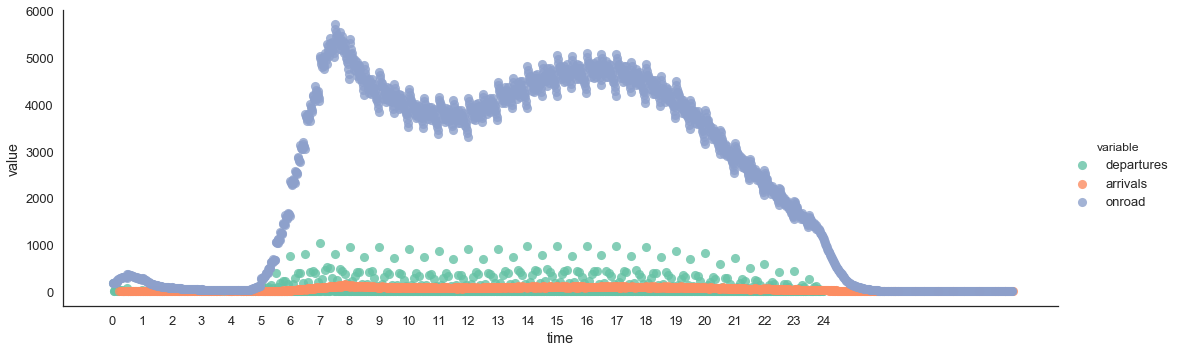

In [17]:
g = sns.lmplot(x="time", y="value", hue="variable", data=melted_df, 
           size=5, aspect=3, line_kws={'linewidth': 0}, ci=None)
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))


The scale thing is an issue here, so lets look at this separately (yeah and the fit is real bad on the onroad, but I don't really care about this here)

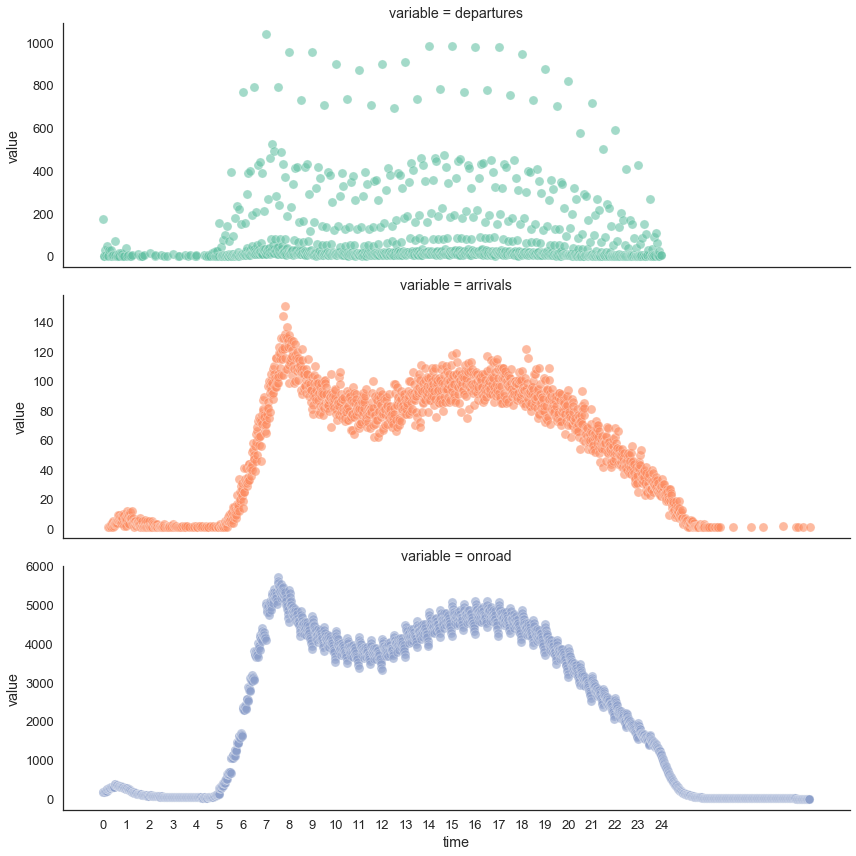

In [18]:
g = sns.FacetGrid(melted_df, row="variable", hue="variable", size=4, aspect=3, sharey=False)
g = g.map(plt.scatter, "time", "value", edgecolor="w", alpha=0.6)
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))


**Note we're not sharing y values!**

We can clearly see the departure patterns, and their effect on onroad. Arrivals look pretty evenly spread. 

Now lets try to throw this at another viz: https://acaird.github.io/computer/python/datascience/2016/06/18/event-density, and just do the proper adjustments for this function to work with our DataFrame

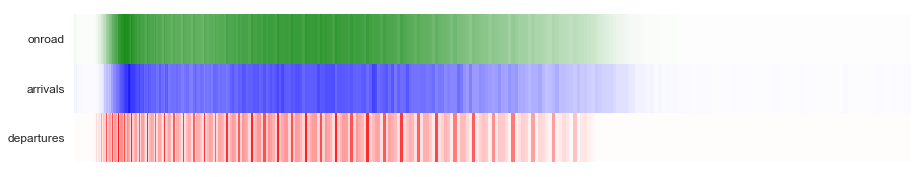

In [19]:
def makebarplot(df):
    time = df.iloc[:, 0]   # extract the x-axis data
    fig = plt.figure()            # get the matplotlib plot figure
    fig.set_size_inches(15, 3)     # set the size of the plot
    ax = fig.add_subplot(1, 1, 1) # add a plot to the figure; Subplot
    # is confusing, though.  The magical "(1, 1, 1)" here means there
    # will be one row, one column, and we are working with plot number
    # 1, all of which is the same as just one plot.  There is a little
    # more documentation on this at:
    # http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot
    # turn off the borders (called spines)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # set all of the ticks to 0 length
    ax.tick_params(axis=u'both', which=u'both',length=0)
    # hide everything about the x-axis
    ax.axes.get_xaxis().set_visible(False)
    # remove grid
    ax.grid(linewidth=0)
    
    barwidth = 1                  # remove gaps between bars
    color = ["red", "blue", "green"] # set the colors for
    for row in range(1, len(color)+1): # make as many rows as colors
        # extract the correct column
        ongoing = df.iloc[:, row]
        # scale the data to the maximum
        ongoing = (ongoing / ongoing.max())

        # draw a black line at the left end
        left = 10
        border_width = 20
        d = border_width
        ax.barh(row, d, barwidth, color="black",
                left=left, edgecolor="none",
                linewidth=0)
        left += d
        # fill in the horizontal bar with the right color density
        # (alpha)
        for d, c in pd.concat((time, ongoing), axis=1).itertuples(index=False):
            ax.barh(row, d, barwidth,
                    alpha=0.9*c+.01,
                    color=color[row-1],
                    left=left,
                    edgecolor="none",
                    linewidth=0)
            left += d

        # draw a black line at the right end
        d = border_width
        ax.barh(row, d, barwidth,
                color="black",
                left=left, edgecolor="none",
                linewidth=0)
    # label the rows
    plt.yticks([1, 2, 3], ['departures', 'arrivals', 'onroad'], size=12)

makebarplot(df.fillna(0)
            .set_index('time').resample('5T').max().reset_index()
            .pipe(to_numeric))

Very nice, but not that great either. We can see the very clear round-minute patterns in departure times, and the more even spread of the arrivals and onroad though.

So to wrap up this overall concurrency viz parade, lets try some other seaborn recipe. We got a feel for the timeseries thing, so lets forget about that for now, and and plot the just distribution instead.

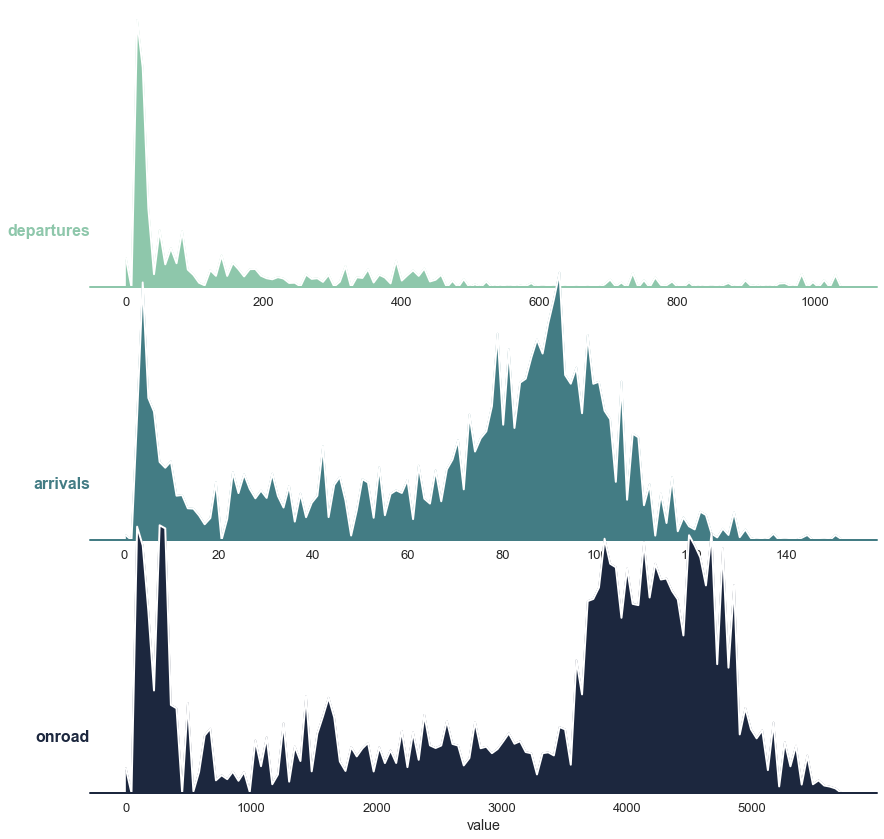

In [20]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(3, rot=-.4, light=.7)
g = sns.FacetGrid(melted_df, row="variable", hue="variable", aspect=3, size=4, palette=pal, sharex=False, sharey=False)

# Draw the densities in a few steps
g.map(sns.kdeplot, "value", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, size=16, fontweight="bold", color=color, 
            ha="right", va="center", transform=ax.transAxes)

g.map(label, "value")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.1)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

Ok, so this is just the distribution for counts per minute of each of our variables. No time-of-day is included here. 

Notice that we're not sharing x and y axes. 

#### On-road per route
Next we combine the concurrency with the the top routes we had previously calculated and plot them together.

In [21]:
route_filter = route_counts.reset_index().route_id
fr = (f[f.route_id.isin(route_filter)].groupby(['trip_id', 'route_id'], as_index=False)
     .agg({'departure_time': 'min',
          'arrival_time': 'max'})
     .pipe(to_timedelta)
     .sort_values(['arrival_time', 'departure_time']))
# converting the categorical to numerical
fr['route_id'] = fr['route_id'].astype('int')
fr.head()

,trip_id,route_id,departure_time,arrival_time
2266,30273777_211217,11073,00:00:00,00:26:14
2269,30274103_211217,11074,00:00:00,00:26:34
1131,24167917_171217,11514,00:00:00,00:28:40
2251,30271372_211217,11513,00:00:00,00:28:46
960,19296737_211217,11523,00:10:00,00:32:03


**Second pedagogical note:** Note the conversion of the categorical. We actually don't want route_id to be categorical right now, because it screws us up when grouping, and gives us the unused categories too, which is exactly what we were trying to filter out.

In [22]:
fr.shape

(2272, 4)

Ok we're very filtered down, nice.

Now do the concurrency math from last time, but with route_id grouping, and output it in a long format for FacetGrid.

In [23]:
departures = (fr[['departure_time', 'route_id']]
              .assign(count=1).rename(columns={'departure_time': 'time'}))
arrivals = (fr[['arrival_time', 'route_id']]
            .assign(count=-1).rename(columns={'arrival_time': 'time'}))

con = pd.concat([departures, arrivals]).set_index('time')

In [24]:
onroad_route = (con.groupby([pd.Grouper(freq='1Min'), 'route_id'])
                .sum()
                .unstack()
                .cumsum()
                .stack()
                .reset_index()
                .pipe(to_numeric))

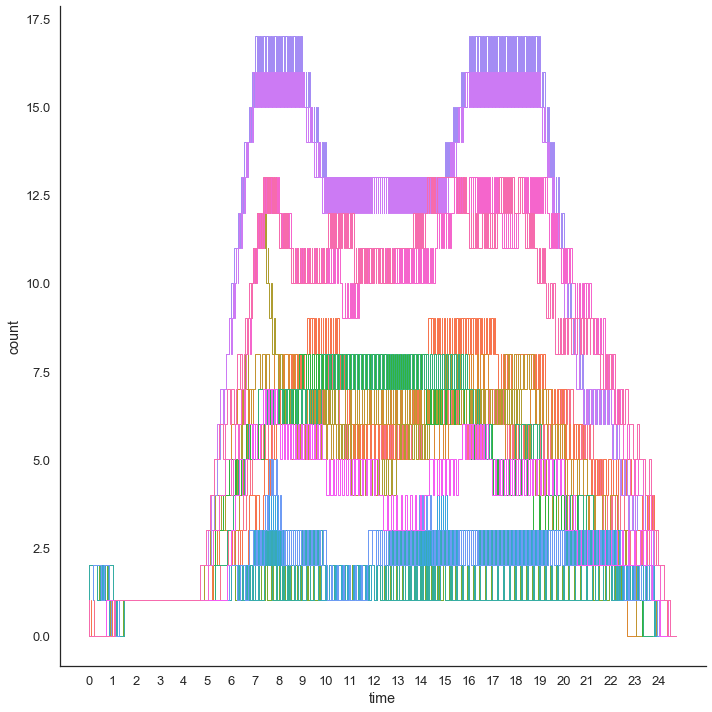

In [25]:
g = sns.FacetGrid(onroad_route, hue='route_id', size=10, aspect=1)
g.map(plt.step, 'time', 'count', linewidth=1,)#.add_legend()
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))


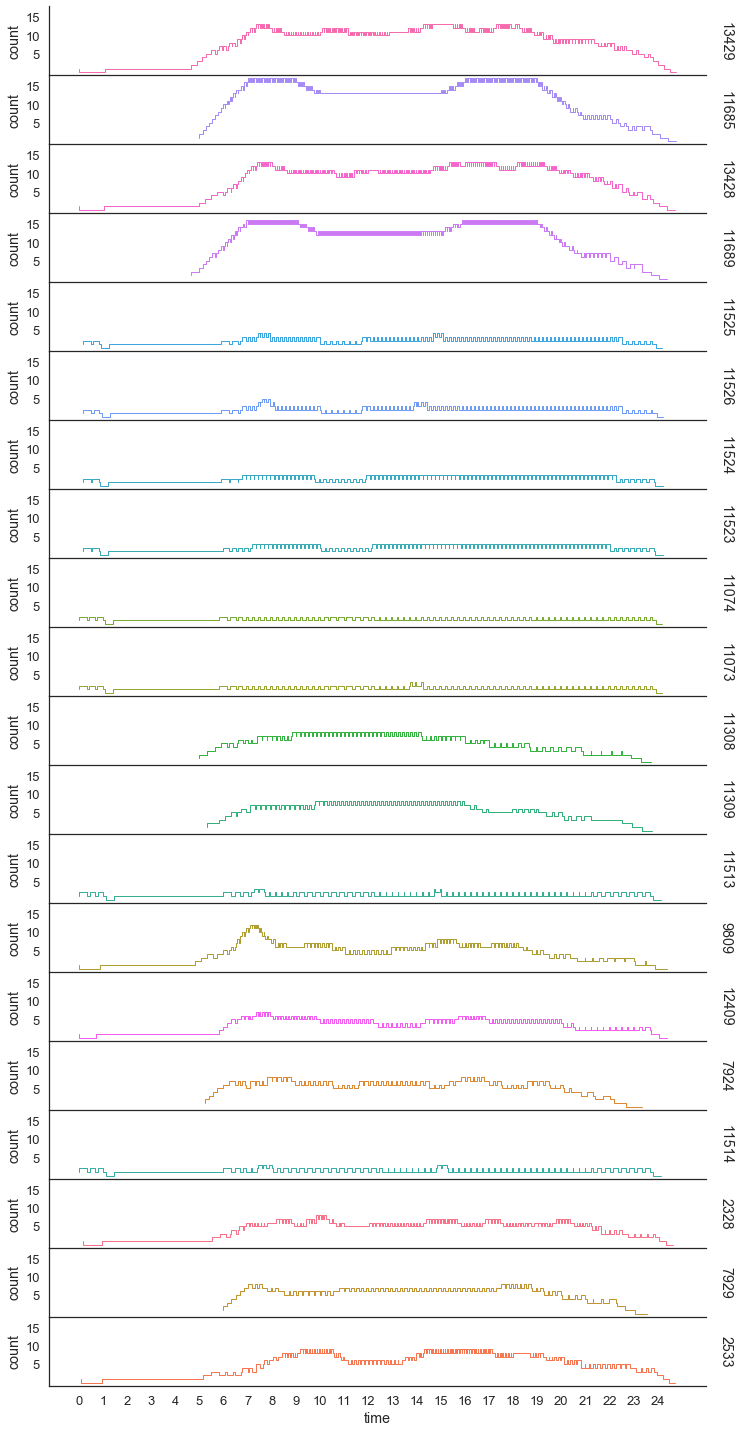

In [26]:
g = sns.FacetGrid(onroad_route, row='route_id', hue='route_id', size=1, aspect=10, 
                  row_order=route_filter.astype('int').tolist(),
                  margin_titles=True)
g.map(plt.step, 'time', 'count', linewidth=1)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)
g.set(yticks=[5, 10, 15])
g.set(xticks=np.arange(25)*60*60*1e9, xticklabels=np.arange(25))

[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(row_template = '{row_name}')
g.despine()

Don't worry, I'll combine the two route directions. The hue kind of works here, but for a final tool we wanna be able to combine the two, since we will probably always want to archive a line for both its directions.

## Geo teaser
Just a tease, next time we'll see some more of these beauties

In [27]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [34]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import inferno, magma

# web mercator coordinates (got them here https://epsg.io/map)
Center_Israel = x_range, y_range = ((3852120,3852120+10e4), (3729820,3729820+10e4/1.3))

plot_width  = int(540)
plot_height = int(plot_width//1.3)

def base_plot(tools='pan,wheel_zoom,box_zoom,reset', active_drag='pan', 
              active_scroll='wheel_zoom', toolbar_location='left',
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, active_drag=active_drag, active_scroll=active_scroll,
               toolbar_location=toolbar_location,
                plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=y_range, outline_line_color=None,
                min_border=0, min_border_left=0, min_border_right=0,
                min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def wgs84_to_web_mercator(df, lon="stop_lon", lat="stop_lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

stops = (s[['stop_lon', 'stop_lat', 'stop_id']].set_index('stop_id')
         .pipe(wgs84_to_web_mercator)
         .assign(counts = f.stop_id.value_counts())
         .sort_values(by='counts', ascending=False))

pal = inferno(256)
c256 = 255 - pd.cut(stops.counts.fillna(0), 256).cat.codes
colors = [pal[c] for _, c in c256.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

p = base_plot()
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops['x'], y=stops['y'], **options)
show(p)

Woooowww... check out that Modi'in Illit Ball of fire :O right between TLV and Jerusalem. Ok, something is definitely off with our data for these lines.


Feel free to pan and zoom as much as you like (select exploration tool to the right)

**Update:** It's not a mistake, the line schedule matches the [schedule](http://www.kavim-t.co.il/download/files/%D7%9C%D7%95%D7%96%20%D7%97%D7%95%D7%A8%D7%A3%20%D7%97%D7%A9%D7%95%D7%9F%20%D7%AA%D7%A9%D7%A2%D7%97%20-%20%D7%9E%D7%95%D7%93%D7%99%D7%A2%D7%99%D7%9F%20%D7%A2%D7%99%D7%9C%D7%99%D7%AA.pdf) on the operator's site, which is even weirder, since it's a local bus making rounds in a 10,000 household settlement...

In [30]:
fr[fr.route_id.isin(['11525', '11526'])] # Line 6 Modi'in Illit, the same holds for line 5

,trip_id,route_id,departure_time,arrival_time
2258,30272244_211217,11525,00:10:00,0 days 00:36:44
2263,30272732_211217,11526,00:10:00,0 days 00:37:13
2259,30272270_211217,11525,00:30:00,0 days 00:56:44
2262,30272721_211217,11526,00:30:00,0 days 00:57:13
2260,30272296_211217,11525,00:50:00,0 days 01:16:44
2261,30272684_211217,11526,00:50:00,0 days 01:17:13
1030,24024085_211217,11525,05:55:00,0 days 06:21:44
1213,24473807_211217,11526,05:55:00,0 days 06:22:13
1031,24024086_211217,11525,06:15:00,0 days 06:41:44
1238,24473833_211217,11526,06:15:00,0 days 06:42:13


## On the next episodes
OK, enough for now, on the next posts: 

* TODO: Turn it all to day-of-week means
* TODO: some dynamic bokeh web applet to use this as a tool
* TODO: Useful Geo visualizations
* TODO: Some graph theory magic ([example](http://kuanbutts.com/2017/12/13/betweenness-centrality-peartree/))